# sscan as 1D Flyer

<font color="red">NOTE</font>: This notebook is under construction!

## 1D step scans using sscan record

Use the [sscan record](https://epics.anl.gov/bcda/synApps/sscan/sscanRecord.html) as an [ophyd Flyer](http://nsls-ii.github.io/bluesky/async.html) for [bluesky](http://nsls-ii.github.io/bluesky) data acquisition.  Consider the case of [1D step scans using sscan record](https://epics.anl.gov/bcda/synApps/sscan/sscanRecord.html#HEADING_1-1).

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(".", "bluesky")))
from instrument.collection import *

I Sat-21:16:32 - ############################################################ startup
I Sat-21:16:32 - logging started
I Sat-21:16:32 - logging level = 10
I Sat-21:16:32 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/collection.py
I Sat-21:16:32 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/mpl/notebook.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Sat-21:16:32 - #### Bluesky Framework ####
I Sat-21:16:32 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_python.py
I Sat-21:16:32 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_bluesky.py
I Sat-21:16:33 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/initialize.py
I Sat-21:16:33 - using databroker catalog 'training'
I Sat-21:16:33 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/metadata.py
I Sat-21:16:33 - #### Devices ####
I Sat-21:16:33 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/area_detector.py
I Sat-21:16:33 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/calculation_records.py
I Sat-21:16:36 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/ioc_stats.py
I Sat-21:16:

In [2]:
from apstools.synApps import SaveData

ioc = "gp:"

save_data = SaveData(f"{ioc}saveData_", name="save_data")

In [3]:
from apstools.synApps import SscanRecord

class MySscanRecord(SscanRecord):
    
    def stage(self):
        super().stage()
        self.select_channels()
    
    def unstage(self):
        super().unstage()
        self.select_channels()

scan = MySscanRecord(f"{ioc}scan1", name="scan")

scan.wait_for_connection()  # sscan records have _many_ channels and fields
scan.select_channels()

# configure the sscan record for data collection:
scan.reset()  # clear out any previous configuration

In [4]:
def setup_sscan_1D():
    # configure sscan record for 1D step scan
    scan.stage_sigs["number_points"] = 6
    scan.stage_sigs["positioner_delay"] = 0
    scan.stage_sigs["positioners.p1.setpoint_pv"] = m1.user_setpoint.pvname
    scan.stage_sigs["positioners.p1.readback_pv"] = m1.user_readback.pvname
    scan.stage_sigs["positioners.p1.start"] = -1
    scan.stage_sigs["positioners.p1.end"] = 0
    scan.stage_sigs["detector_delay"] = 0.1
    scan.stage_sigs["detectors.d01.input_pv"] = scaler1.channels.chan03.s.pvname
    scan.stage_sigs["detectors.d02.input_pv"] = scaler1.channels.chan02.s.pvname
    scan.stage_sigs["triggers.t1.trigger_pv"] = scaler1.count.pvname

    # configure saveData for data collection into MDA files:
    save_data.stage_sigs["file_system"] = "/tmp"
    save_data.stage_sigs["subdirectory"] = "saveData"
    save_data.stage_sigs["base_name"] = "sscan1_"
    save_data.stage_sigs["next_scan_number"] = 1
    save_data.stage_sigs["comment1"] = "testing"
    save_data.stage_sigs["comment2"] = "configured and run from ophyd"

In [42]:
scaler1.channels.chan03.name

'scaler1_channels_chan03'

In [36]:
dir(scan);

In [17]:
scan.stage()
save_data.stage()

[SaveData(prefix='gp:saveData_', name='save_data', read_attrs=['file_system', 'subdirectory', 'base_name', 'next_scan_number', 'comment1', 'comment2', 'write_1D_each_point', 'max_retries', 'retry_wait_s', 'full_path_name', 'full_name', 'message', 'status', 'write_count_current', 'write_count_total', 'write_count_abandoned'], configuration_attrs=[])]

In [37]:
dir(scan);

In [34]:
scan.positioners.p1.array.get(use_monitor=False, as_numpy=True)[:7]

array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0. ])

In [19]:
device_read2table(scan)

================================== ====================== ==========================
name                               value                  timestamp                 
================================== ====================== ==========================
scan_scan_phase                    0                      2021-08-21 21:51:13.837783
scan_data_state                    7                      2021-08-21 21:51:13.837783
scan_data_ready                    1                      2021-08-21 21:51:13.837783
scan_scan_busy                     0                      2021-08-21 21:51:13.837783
scan_alert_flag                    0                      2021-08-21 21:18:07.476809
scan_alert_message                 SCAN Complete          2021-08-21 21:51:13.837783
scan_current_point                 6                      2021-08-21 21:51:13.837783
scan_pasm                          0                      1989-12-31 18:00:00       
scan_execute_scan                  0                      2021-08

In [54]:
from ophyd.flyers import FlyerInterface

class SscanFlyer_1D_StepSimple(FlyerInterface):
    
    sscan = None
    
    def __init__(self, sscan, *args, **kwargs):
        self.sscan = sscan
        self._acquiring = False

        super().__init__(*args, **kwargs)

    def kickoff(self):
        # scan.reset()
        setup_sscan_1D(scan)
        scan.stage()
        yield from bp.mv(self.sscan.execute_scan, 1)  # start the sscan record
        self._acquiring = True

        status = DeviceStatus(self)
        status.set_finished()  # TODO: means that kickoff was successful?
        return status

    def complete(self):
        """Wait for sscan to complete."""
        if not self._acquiring:
            raise RuntimeError('Not acquiring')

        st = DeviceStatus(self)
        cb_started = False

        def execute_scan_cb(value, timestamp, **kwargs):
            value = int(value)
            if cb_started and value == 0:
                scan.unstage()
                self._acquiring = False
                self.execute_scan.unsubscribe(execute_scan_cb)
                st.set_finished()

        self.execute_scan.subscribe(execute_scan_cb)
        self.execute_scan.set(1)
        cb_started = True
        return st

#     def describe_collect(self):
#         # TODO:
#         # http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.describe_collect.html
#         # Provide schema & meta-data from collect()
#         # pass   # -> Dict[str, Dict]
#         return {self.stream_name: None}

#     def collect(self):
#         """Retrieve all collected data (after complete())."""
#         if self._acquiring:
#             raise RuntimeError("Acquisition still in progress. Call complete() first.")
#         # http://nsls-ii.github.io/ophyd/generated/ophyd.flyers.FlyerInterface.collect.html
#         # Retrieve data from the flyer as proto-events

#         ts = time.time()
#         n = self.sscan.current_point.get()
#         m = scan.positioners.p1.array.get(use_monitor=False, as_numpy=True)[:n]
#         d1 = scan.detectors.d01.array.get(use_monitor=False, as_numpy=True)[:n]
#         d2 = scan.detectors.d02.array.get(use_monitor=False, as_numpy=True)[:n]

#         yield {
#             'data': {
#                 m1.name: m,
#                 scaler1.channels.chan03.chname.get(): d1,  # TODO: correct name to use here?
#                 scaler1.channels.chan02.chname.get(): d2,  # TODO: correct name to use here?
#             },
#             'timestamps': {
#                 m1.name: ts,
#                 scaler1.channels.chan03.chname.get(): ts,
#                 scaler1.channels.chan02.chname.get(): ts,
#             },
#             'time': ts
#         }

In [55]:
scan_flyer = SscanFlyer_1D_StepSimple(scan)

In [56]:
RE(bp.fly([scan_flyer]))



Transient Scan ID: 356     Time: 2021-08-21 22:52:41
Persistent Unique Scan ID: '7604d8a1-1b1a-4281-a873-aa4815185c53'
New stream: 'baseline'


Run aborted
Traceback (most recent call last):
  File "/home/mintadmin/Apps/anaconda/envs/bluesky_2021_1/lib/python3.8/site-packages/bluesky/run_engine.py", line 1815, in _kickoff
    ret.add_callback(done_callback)
AttributeError: 'generator' object has no attribute 'add_callback'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mintadmin/Apps/anaconda/envs/bluesky_2021_1/lib/python3.8/site-packages/bluesky/run_engine.py", line 1341, in _run
    msg = self._plan_stack[-1].throw(
  File "/home/mintadmin/Apps/anaconda/envs/bluesky_2021_1/lib/python3.8/site-packages/bluesky/preprocessors.py", line 1307, in __call__
    return (yield from plan)
  File "/home/mintadmin/Apps/anaconda/envs/bluesky_2021_1/lib/python3.8/site-packages/bluesky/preprocessors.py", line 1162, in baseline_wrapper
    return (yield from plan_mutator(plan, insert_baseline))
  File "/home/mintadmin/Apps/anaconda/envs/bluesky_2021_1/lib/python3.8/site

AttributeError: 'generator' object has no attribute 'finished_cb'

## MockFlyer with motor and pseudo-detector

ophyd's *MockFlyer* example : https://github.com/NSLS-II/ophyd/blob/master/ophyd/sim.py#L546

In [6]:
import asyncio
from collections import deque
from collections import OrderedDict
from ophyd import DeviceStatus
import time

class MockFlyer:
    """
    Class for mocking a flyscan API implemented with stepper motors.
    """

    def __init__(self, name, detector, motor, start, stop, num, loop=None):
        self.name = name
        self.parent = None
        self._mot = motor
        self._detector = detector
        self._steps = np.linspace(start, stop, num)
        self._data = deque()
        self._completion_status = None
        if loop is None:
            loop = asyncio.get_event_loop()
        self.loop = loop

    def __setstate__(self, val):
        name, detector, motor, steps = val
        self.name = name
        self.parent = None
        self._mot = motor
        self._detector = detector
        self._steps = steps
        self._completion_status = None
        self.loop = asyncio.get_event_loop()

    def __getstate__(self):
        return (self.name, self._detector, self._mot, self._steps)

    def read_configuration(self):
        return OrderedDict()

    def describe_configuration(self):
        return OrderedDict()

    def describe_collect(self):
        dd = dict()
        dd.update(self._mot.describe())
        dd.update(self._detector.describe())
        return {'stream_name': dd}

    def complete(self):
        if self._completion_status is None:
            raise RuntimeError("No collection in progress")
        return self._completion_status

    def kickoff(self):
        if self._completion_status is not None:
            raise RuntimeError("Already kicked off.")
        self._data = deque()

        self._future = self.loop.run_in_executor(None, self._scan)
        st = DeviceStatus(device=self)
        self._completion_status = st
        self._future.add_done_callback(lambda x: st._finished())
        return st

    def collect(self):
        if self._completion_status is None or not self._completion_status.done:
            raise RuntimeError("No reading until done!")
        self._completion_status = None

        yield from self._data

    def _scan(self):
        "This will be run on a separate thread, started in self.kickoff()"
        time.sleep(.1)
        for p in self._steps:
            stat = self._mot.set(p)
            while True:
                if stat.done:
                    break
                time.sleep(0.01)
            stat = self._detector.trigger()
            while True:
                if stat.done:
                    break
                time.sleep(0.01)

            event = dict()
            event['time'] = time.time()
            event['data'] = dict()
            event['timestamps'] = dict()
            for r in [self._mot, self._detector]:
                d = r.read()
                for k, v in d.items():
                    event['data'][k] = v['value']
                    event['timestamps'][k] = v['timestamp']
            self._data.append(event)

    def stop(self, *, success=False):
        pass


In [7]:
mflyer = MockFlyer('mflyer', noisy, m1, -1.1, 1.2, 29)



Transient Scan ID: 353     Time: 2021-08-20 23:08:50
Persistent Unique Scan ID: '3934b930-5a91-4ae2-8ce2-380413e1b7c9'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 23:08:57.4 |   -1.10000 |   45.11507 |
|         2 | 23:08:58.0 |   -0.88000 |   65.13253 |
|         3 | 23:08:58.6 |   -0.66000 |  102.77275 |
|         4 | 23:08:59.1 |   -0.44000 |  177.91237 |
|         5 | 23:08:59.6 |   -0.22000 |  403.98239 |
|         6 | 23:09:00.1 |    0.00000 | 1540.96112 |
|         7 | 23:09:00.6 |    0.22000 | 84035.73578 |
|         8 | 23:09:01.1 |    0.44000 | 1725.22459 |
|         9 | 23:09:01.6 |    0.66000 |  417.99179 |
|        10 | 23:09:02.1 |    0.88000 |  184.99646 |
|        11 | 23:09:02.6 |    1.10000 |  103.51405 |
+-----------+------------+------------+------------+
generator scan ['3934b930'] (scan num:

('3934b930-5a91-4ae2-8ce2-380413e1b7c9',)

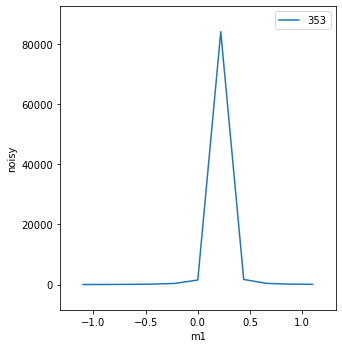

In [8]:
RE(bp.scan([noisy], m1, -1.1, 1.1, 11))

In [9]:
run = cat[-1]
run.primary.read()

<xarray.Dataset>
Dimensions:           (time: 11)
Coordinates:
  * time              (time) float64 1.63e+09 1.63e+09 ... 1.63e+09 1.63e+09
Data variables:
    m1                (time) float64 -1.1 -0.88 -0.66 -0.44 ... 0.66 0.88 1.1
    m1_user_setpoint  (time) float64 -1.1 -0.88 -0.66 -0.44 ... 0.66 0.88 1.1
    noisy             (time) float64 45.12 65.13 102.8 ... 418.0 185.0 103.5